# Modelo Original 

Para la construcción del modelo original se plantea un emsable del modelo ARMA y el modelo TL smoother. La ecuación para la construcción del modelo se define así: 


$$\alpha_t \cdot P_{ARMA_t} + (1 - \alpha_t) \cdot P_{TLsm_t}$$

Donde $\alpha_t$ es un factor de ponteración para el aporte de las prediciones por obvservación de cada modelo,  
$ P_{ARMA_t}$ las predicciones del modelo ARMA y  
$P_{TLsm_t}$ las predicciones del modelo TL smoother.


In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest

In [2]:
url = 'https://raw.githubusercontent.com/evgomez98/wind_speed/main/wind_dataset.csv'
df = pd.read_csv(url)

Traemos los dos modelos en cuestión, iniciando por la división de los datos:

In [3]:
tau_test = 365
tau_val  = 365

train = df['WIND'][:-(tau_val + tau_test)].copy()
val   = df['WIND'][-(tau_val + tau_test):-tau_test].copy()
test  = df['WIND'][-tau_test:].copy()

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

Train: 5844, Validation: 365, Test: 365


In [4]:
def tlsmooth(y, delta_, y_tilde_start=None, lambda_start=1):
    T = len(y)
    
    Qt = np.zeros(T)
    Dt = np.zeros(T)
    y_tilde = np.zeros(T)
    lambd = np.zeros(T)
    err = np.zeros(T)
    
    lambd[0] = lambda_start
    if y_tilde_start is None:
        y_tilde[0] = y[0]
    else:
        y_tilde[0] = y_tilde_start
    
    for i in range(1, T):
        err[i] = y[i] - y_tilde[i-1]
        Qt[i] = delta_ * err[i] + (1 - delta_) * Qt[i-1]
        Dt[i] = delta_ * abs(err[i]) + (1 - delta_) * Dt[i-1]
        lambd[i] = abs(Qt[i] / Dt[i])
        y_tilde[i] = lambd[i] * y[i] + (1 - lambd[i]) * y_tilde[i-1]
    
    return np.column_stack((y_tilde, lambd, err, Qt, Dt))

In [5]:
delta_ = 0.8
train_result = tlsmooth(train, delta_)

Metricas del TLsmoother 

In [6]:
index = 'TLsmooth test Δ = 0.8'

test = test.reset_index(drop=True)
test_result = tlsmooth(test, delta_)

test_pred_TLS = test_result[:, 0]  

mae = mean_absolute_error(test, test_pred_TLS)
sse = np.sum((test - test_pred_TLS) ** 2)
mape = np.mean(np.abs((test - test_pred_TLS) / test)) * 100
msd = mean_squared_error(test, test_pred_TLS)
r2 = r2_score(test, test_pred_TLS) 

ljung_box = acorr_ljungbox(test - test_pred_TLS, lags=[90], return_df=True)

normality_test_stat, normality_p_value = normaltest(test - test_pred_TLS)

df_acc = pd.DataFrame({'MAE': [mae],
                    'SSE': [sse],
                    'MAPE': [mape],
                    'MSD': [msd],
                    'R2': [r2],
                    'Ljung-Box (p-value)': [ljung_box['lb_pvalue'].iloc[0]],
                    'Normalidad (p-value)': [normality_p_value]},
                    index= [index])
df_acc.head()

,MAE,SSE,MAPE,MSD,R2,Ljung-Box (p-value),Normalidad (p-value)
TLsmooth test Δ = 0.8,0.65569,399.159125,8.631877,1.093587,0.96004,0.002216,4.763272e-10


In [7]:
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.tsa.api as smtsa
import statsmodels.tsa.arima.model as arima_model
from statsmodels.tsa.arima.model import ARIMA

best_order = (1, 0, 2)
model = ARIMA(train, order=best_order )

In [8]:
def arima_rolling(train, val, test, best_order):
    history = list(train) + list(val)
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]  
        predictions.append(yhat)
        obs = test[t] 
        history.append(obs)  
        
        print(f'Predicted={yhat:.3f}, Expected={obs:.3f}')
        
    return predictions

In [9]:
test = test.tolist()
test_pred_ARMA  = arima_rolling(train, val, test, best_order)

Predicted=13.580, Expected=14.710
Predicted=13.275, Expected=17.080
Predicted=14.613, Expected=21.960
Predicted=17.140, Expected=8.380
Predicted=9.518, Expected=13.880
Predicted=13.906, Expected=11.290
Predicted=10.866, Expected=8.080
Predicted=9.717, Expected=8.120
Predicted=9.446, Expected=17.330
Predicted=14.245, Expected=16.620
Predicted=13.162, Expected=19.410
Predicted=15.607, Expected=11.580
Predicted=11.108, Expected=9.870
Predicted=11.099, Expected=4.170
Predicted=7.308, Expected=1.580
Predicted=6.000, Expected=7.870
Predicted=8.882, Expected=8.330
Predicted=8.318, Expected=7.920
Predicted=8.452, Expected=10.290
Predicted=9.777, Expected=13.790
Predicted=11.623, Expected=11.080
Predicted=10.170, Expected=15.710
Predicted=13.321, Expected=13.500
Predicted=11.676, Expected=13.920
Predicted=12.596, Expected=8.330
Predicted=9.297, Expected=16.500
Predicted=14.310, Expected=11.630
Predicted=10.562, Expected=15.870
Predicted=13.975, Expected=25.540
Predicted=18.626, Expected=6.080
P

In [12]:
index = 'ARMA rolling (1, 0, 2) test' 

test_pred_ARMA = np.array(test_pred_ARMA)        

mae = mean_absolute_error(test, test_pred_ARMA)
sse = np.sum((test - test_pred_ARMA) ** 2)
mape = np.mean(np.abs((test - test_pred_ARMA) / test)) * 100
msd = mean_squared_error(test, test_pred_ARMA)
r2 = r2_score(test, test_pred_ARMA) 

ljung_box = acorr_ljungbox(test - test_pred_ARMA, lags=[10], return_df=True)

normality_test_stat, normality_p_value = normaltest(test - test_pred_ARMA)

df_acc = pd.DataFrame({'MAE': [mae],
                    'SSE': [sse],
                    'MAPE': [mape],
                    'MSD': [msd],
                    'R2': [r2],
                    'Ljung-Box (p-value)': [ljung_box['lb_pvalue'].iloc[0]],
                    'Normalidad (p-value)': [normality_p_value]},
                    index= [index])
df_acc.head()

,MAE,SSE,MAPE,MSD,R2,Ljung-Box (p-value),Normalidad (p-value)
"ARMA rolling (1, 0, 2) test",3.326124,6425.376786,61.322275,17.603772,0.356756,0.725282,0.001373


Para el emsamble  del modelo se define la función que tendrá como entrada las predicciones de ambos modelos y el factor de ponderación $\alpha$:

Ahora, a través de un `loop` atomatizamos la busqueda de $\alpha$ que minimice el error absoluto promedio. 

In [42]:
import numpy as np

def ensamble_pred(ses_pred, arima_pred, test):
    ses_pred = np.array(ses_pred).flatten() if np.ndim(ses_pred) > 1 else np.array(ses_pred)
    arima_pred = np.array(arima_pred).flatten() if np.ndim(arima_pred) > 1 else np.array(arima_pred)
    test = np.array(test).flatten() if np.ndim(test) > 1 else np.array(test)
    
    predictions = []
    
    for i in range(len(test)):
        error_ses = abs(ses_pred[i] - test[i])
        error_arima = abs(arima_pred[i] - test[i])
        
        if error_arima > error_ses:
            alpha = 1  # priorizar ARIMA
        elif error_ses > error_arima:
            alpha = 0  # priorizar SES
        else:
            alpha = 0.5 
        
        pred = alpha * ses_pred[i] + (1 - alpha) * arima_pred[i]
        predictions.append(pred)
        
    return np.array(predictions)

In [43]:
final_ensamble_pred  = ensamble_pred(test_pred_TLS, test_pred_ARMA, test)

Ahora probamos el modelo ensamblado:

In [44]:
index = 'Modelo Ensamblado Adaptativo'
test_pred = final_ensamble_pred 

mae = mean_absolute_error(test, test_pred)
sse = np.sum((test - test_pred) ** 2)
mape = np.mean(np.abs((test - test_pred) / test)) * 100
msd = mean_squared_error(test, test_pred)
r2 = r2_score(test,test_pred) 

ljung_box = acorr_ljungbox(test - test_pred, lags=[90], return_df=True)

normality_test_stat, normality_p_value = normaltest(test - test_pred)

df_acc = pd.DataFrame({'MAE': [mae],
                    'SSE': [sse],
                    'MAPE': [mape],
                    'MSD': [msd],
                    'R2': [r2],
                    'Ljung-Box (p-value)': [ljung_box['lb_pvalue'].iloc[0]],
                    'Normalidad (p-value)': [normality_p_value]},
                    index= [index])
df_acc.head()

,MAE,SSE,MAPE,MSD,R2,Ljung-Box (p-value),Normalidad (p-value)
Modelo Ensamblado Adaptativo,0.56752,298.887579,7.769357,0.81887,0.970078,0.007334,8.116338e-09


Se concluye que las metricas de error asociadas al modelo emsamblado son mejores que los dos modelos bench mark utilizados como insumo, sin embargo los supuestos de normaidad y no autocorrelación no se cumplen.

In [49]:
import plotly.graph_objects as go
def plot_model(train, val, test, final_ensamble_pred, title):
  
    train = np.array(train)
    val = np.array(val)
    test = np.array(test)
    test_pred = np.array(final_ensamble_pred)

   
    train_index = np.arange(0, len(train))
    val_index = np.arange(len(train), len(train) + len(val))
    test_index = np.arange(len(train) + len(val), len(train) + len(val) + len(test))
    test_pred_index = test_index  

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_index, y=train, mode='lines', name='Train', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=val_index, y=val, mode='lines', name='Validation', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=test_index, y=test, mode='lines', name='Test', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=test_pred_index, y=test_pred, mode='lines', name='Prediction', line=dict(color='red', dash='dash')))

    fig.update_layout(
        title=title,
        xaxis_title="Observaciones",
        yaxis_title="Valores",
        legend=dict(x=0, y=1, traceorder="normal"),
        plot_bgcolor='rgba(0,0,0,0)',
        width=1000, height=600
    )

    fig.show()

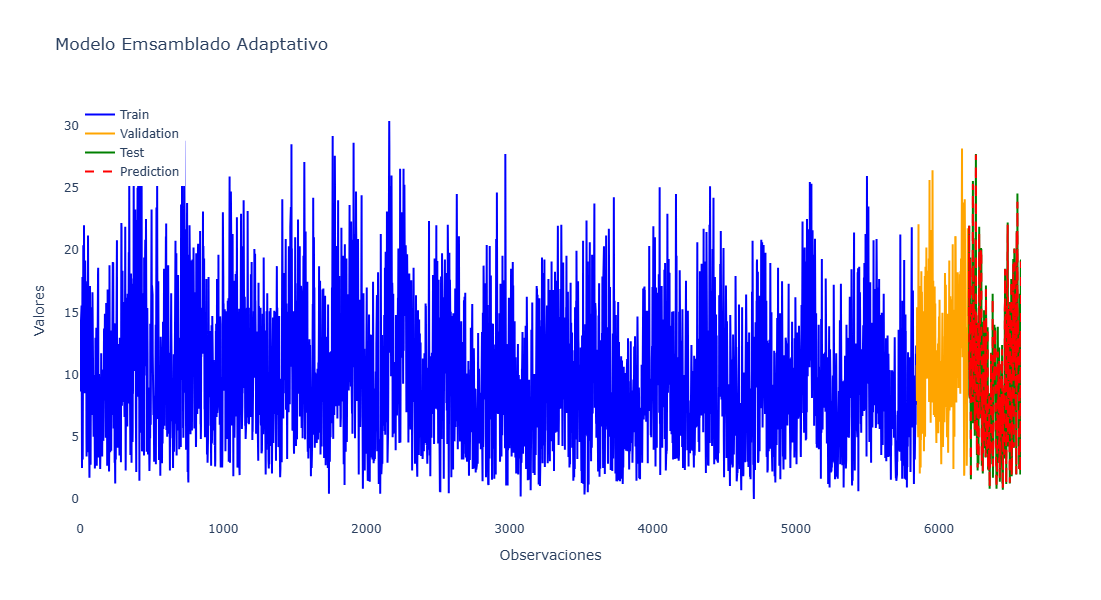

In [51]:
plot_model(train, val, test, final_ensamble_pred, 'Modelo Emsamblado Adaptativo')